# 04_analyze_results
Aggregates metrics, produces plots, and writes analysis artifacts from master predictions.

**Inputs:**
- `results/svm_bioclip/master_predictions_latest.csv` (or latest timestamped master)
- `data/processed/final_data_no_ixodes.json`

**Outputs:**
- `results/svm_bioclip/aggregated_metrics.csv`
- `results/svm_bioclip/shot_summary.csv`
- `results/svm_bioclip/per_species_accuracy.csv`
- `results/svm_bioclip/*.png` plots
- `results/svm_bioclip/analysis/ticks_analysis.parquet`
- `results/svm_bioclip/analysis/top_misclassified_samples.csv`
- `results/svm_bioclip/analysis/top10_per_species.csv`


**Run instructions**
- Run Blocks 7–10.
- Inputs: `results/svm_bioclip/latest/run_id.txt` and `results/svm_bioclip/runs/<RUN_ID>/predictions.csv`.
- Outputs (per run): `results/svm_bioclip/runs/<RUN_ID>/analysis/` (CSV + parquet).
- Outputs (latest): `results/svm_bioclip/latest/analysis/`.


In [1]:
import sys
from pathlib import Path
repo_root = Path.cwd().resolve().parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))
from src.utils.paths import load_paths
paths = load_paths()


In [2]:
from pathlib import Path
LATEST_DIR = Path("results") / "svm_bioclip" / "latest"
RUN_ID = (LATEST_DIR / "run_id.txt").read_text().strip()
RUN_DIR = Path("results") / "svm_bioclip" / "runs" / RUN_ID
ANALYSIS_ROOT = RUN_DIR / "analysis"
ANALYSIS_ROOT.mkdir(parents=True, exist_ok=True)
LATEST_ANALYSIS = LATEST_DIR / "analysis"
LATEST_ANALYSIS.mkdir(parents=True, exist_ok=True)
print(f"[RUN] RUN_ID={RUN_ID}")
print(f"[RUN] RUN_DIR={RUN_DIR}")


FileNotFoundError: [Errno 2] No such file or directory: 'results/svm_bioclip/latest/run_id.txt'

In [ ]:
# === Block 7 — Aggregate metrics per shot and per species (run-aware, with 95% CIs) ===

# Load the latest master automatically (prefer the stable pointer, else newest timestamped file)
df = pd.read_csv(RUN_DIR / "predictions.csv")
print(f"[LOAD] Using predictions = {RUN_DIR / "predictions.csv"}")


# Ensure types and stable ordering
df["shots"]  = df["shots"].astype(int)
df["run_id"] = df["run_id"].astype(int)
df["correct"] = df["correct"].astype(int)
df = df.sort_values(["shots", "run_id", "sample_id"]).reset_index(drop=True)

# ---- helper: 95% CI via normal approx (works well with >=30 runs); fall back if n<2
import numpy as _np

def mean_std_ci95(x):
    x = _np.asarray(x, dtype=float)
    n = x.size
    mean = float(_np.mean(x)) if n else float("nan")
    std  = float(_np.std(x, ddof=1)) if n > 1 else float("nan")
    sem  = std / _np.sqrt(n) if (n and _np.isfinite(std)) else float("nan")
    ci95 = 1.96 * sem if _np.isfinite(sem) else float("nan")
    return mean, std, n, ci95

# --- 1) Per-run summaries (overall + macro) ---
# overall acc per (shots, run)
run_overall = (
    df.groupby(["shots", "run_id"], as_index=False)["correct"]
      .mean()
      .rename(columns={"correct": "overall_acc"})
)

# per-species acc within a run
per_run_species = (
    df.groupby(["shots", "run_id", "species_true"], as_index=False)["correct"]
      .mean()
      .rename(columns={"correct": "spec_acc"})
)

# macro acc per (shots, run) = mean over species present in that run
run_macro = (
    per_run_species.groupby(["shots", "run_id"], as_index=False)["spec_acc"]
      .mean()
      .rename(columns={"spec_acc": "macro_acc"})
)

agg_runs = (
    run_overall.merge(run_macro, on=["shots", "run_id"])
               .sort_values(["shots", "run_id"])
               .reset_index(drop=True)
)
agg_runs.to_csv(ANALYSIS_ROOT / "aggregated_metrics.csv", index=False)

# --- 2) Aggregate per shot (mean ± sd and 95% CIs over runs) ---
shot_rows = []
for K, g in agg_runs.groupby("shots"):
    m_macro, s_macro, n_macro, ci_macro = mean_std_ci95(g["macro_acc"].values)
    m_over , s_over , n_over , ci_over  = mean_std_ci95(g["overall_acc"].values)
    shot_rows.append({
        "shots": K,
        "mean_macro": m_macro, "std_macro": s_macro, "ci95_macro": ci_macro, "n_runs_macro": n_macro,
        "mean_overall": m_over, "std_overall": s_over, "ci95_overall": ci_over, "n_runs_overall": n_over
    })

agg_shots = pd.DataFrame(shot_rows).sort_values("shots")
agg_shots.to_csv(ANALYSIS_ROOT / "shot_summary.csv", index=False)
display(agg_shots)

# --- 3) Per-species learning curves (mean ± sd and 95% CIs over runs) ---
# First: per-run per-species (already computed as per_run_species)
species_rows = []
for (K, sp), g in per_run_species.groupby(["shots", "species_true"]):
    m, s, n, ci = mean_std_ci95(g["spec_acc"].values)
    species_rows.append({
        "shots": K,
        "species": sp,
        "acc_mean": m,
        "acc_std": s,
        "acc_ci95": ci,
        "n_runs": n,         # note: may be < RUNS if species dropped for that K
    })

per_species_summary = (
    pd.DataFrame(species_rows)
      .sort_values(["species", "shots"])
      .reset_index(drop=True)
)

# keep your original filename and add CI column
per_species_summary.to_csv(ANALYSIS_ROOT / "per_species_accuracy.csv", index=False)
display(per_species_summary.head())

# (optional convenience alias for downstream plotting code that expected 'acc_std')
per_species = per_species_summary.rename(columns={"acc_std": "acc_std"})  # no-op; kept for compatibility


[LOAD] Using MASTER = master_predictions_latest.csv


,shots,mean_macro,std_macro,ci95_macro,n_runs_macro,mean_overall,std_overall,ci95_overall,n_runs_overall
0,1,0.628506,0.093664,0.018358,100,0.744137,0.108818,0.021328,100
1,3,0.739751,0.054564,0.010695,100,0.818554,0.041247,0.008084,100
2,5,0.784969,0.038691,0.007583,100,0.841196,0.036112,0.007078,100
3,10,0.838781,0.030574,0.005992,100,0.864060,0.024445,0.004791,100
4,25,0.889281,0.027873,0.005463,100,0.902394,0.015138,0.002967,100


,shots,species,acc_mean,acc_std,acc_ci95,n_runs
0,1,Amblyomma americanum,0.461236,0.176022,0.034500,100
1,3,Amblyomma americanum,0.664023,0.154262,0.030235,100
2,5,Amblyomma americanum,0.721412,0.133657,0.026197,100
3,10,Amblyomma americanum,0.749625,0.097595,0.019129,100
4,25,Amblyomma americanum,0.812769,0.060364,0.011831,100


## Block 8 - Plots

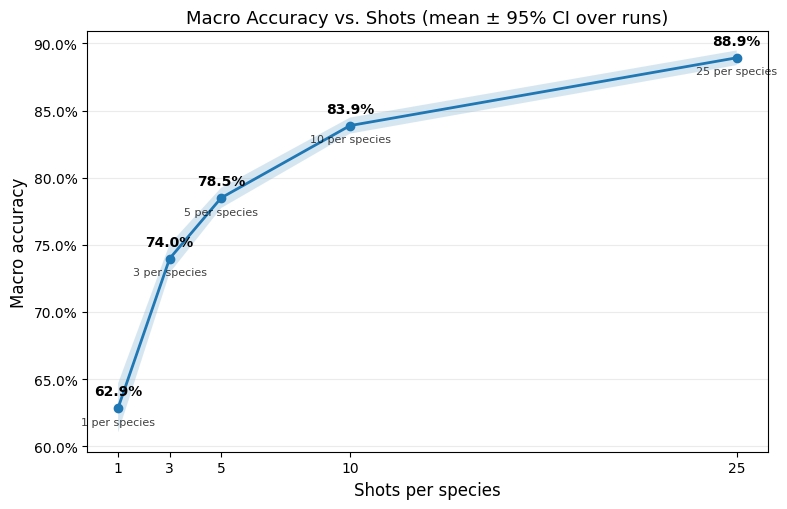

[PLOT] saved ../results/svm_bioclip/species_learning_curves_page01.png


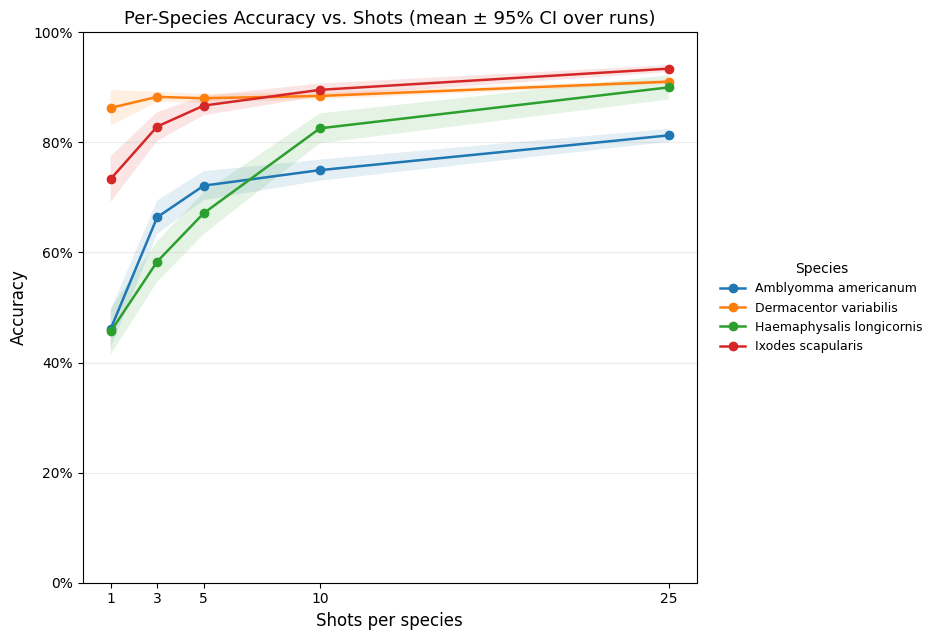

In [ ]:
# === Block 8 — Visualization: Macro curve + per-species learning curves (CI, annotations, pagination) ===
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import math
import numpy as np

# ---------- 1) Macro accuracy with 95% CI ribbon + value annotations ----------
fig, ax = plt.subplots(figsize=(8.0, 5.2))

x  = agg_shots["shots"].to_numpy()
y  = agg_shots["mean_macro"].to_numpy()   # 0..1
ci = agg_shots["ci95_macro"].to_numpy()   # half-width

ax.plot(x, y, marker="o", linewidth=2.0)
ax.fill_between(x, y - ci, y + ci, alpha=0.18, linewidth=0)

# Annotate each dot: % above, and "K per species" below
for xi, yi in zip(x, y):
    ax.annotate(f"{yi*100:.1f}%", (xi, yi),
                textcoords="offset points", xytext=(0, 9),
                ha="center", fontsize=10, fontweight="semibold")
    ax.annotate(f"{int(xi)} per species", (xi, yi),
                textcoords="offset points", xytext=(0, -12),
                ha="center", fontsize=8, alpha=0.75)

ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.set_xlabel("Shots per species", fontsize=12)
ax.set_ylabel("Macro accuracy", fontsize=12)
ax.set_title("Macro Accuracy vs. Shots (mean ± 95% CI over runs)", fontsize=13)
ax.set_xticks(x)
ax.grid(True, axis="y", alpha=0.25)
plt.tight_layout()
# plt.savefig(RESULTS_ROOT / "macro_accuracy_curve.png", dpi=200)
plt.show()

# ---------- 2) Per-species learning curves (95% CI, sorted, paginated) ----------
# We’ll sort species by accuracy at the largest K to highlight easy ↔ hard taxa
K_max = int(np.max(per_species_summary["shots"]))
lastK = (per_species_summary.query("shots == @K_max")
         .sort_values("acc_mean", ascending=False)["species"].tolist())

species_order = lastK
shots_grid = np.sort(per_species_summary["shots"].unique())

# Pagination so legends don’t explode; 10–12 species per page is comfy for talks
SPEC_PER_PAGE = 12
num_pages = math.ceil(len(species_order) / SPEC_PER_PAGE)

for page in range(num_pages):
    start = page * SPEC_PER_PAGE
    end   = start + SPEC_PER_PAGE
    subset = species_order[start:end]
    subdf = per_species_summary[per_species_summary["species"].isin(subset)].copy()

    fig, ax = plt.subplots(figsize=(9.5, 6.5))
    for sp, g in subdf.groupby("species"):
        g = (g.set_index("shots")
               .reindex(shots_grid)
               .reset_index())
        y  = g["acc_mean"].to_numpy()
        ci = g["acc_ci95"].to_numpy()
        ax.plot(shots_grid, y, marker="o", linewidth=1.8, label=sp)
        # CI ribbon (nan-safe)
        lo = (y - ci); hi = (y + ci)
        ax.fill_between(shots_grid, lo, hi, alpha=0.12, linewidth=0)

    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax.set_xticks(shots_grid)
    ax.set_ylim(0, 1.0)
    ax.set_xlabel("Shots per species", fontsize=12)
    ax.set_ylabel("Accuracy", fontsize=12)
    ttl = "Per-Species Accuracy vs. Shots (mean ± 95% CI over runs)"
    if num_pages > 1:
        ttl += f"  —  page {page+1}/{num_pages}"
    ax.set_title(ttl, fontsize=13)
    ax.grid(True, axis="y", alpha=0.25)

    # Put legend outside; scroll-proof in slides
    leg = ax.legend(title="Species", loc="center left", bbox_to_anchor=(1.02, 0.5),
                    frameon=False, fontsize=9, title_fontsize=10)
    plt.tight_layout()
    out = RESULTS_ROOT / f"species_learning_curves_page{page+1:02d}.png"
#     plt.savefig(out, dpi=200, bbox_inches="tight")
    print(f"[PLOT] saved {out}")
    plt.show()


[PLOT] saved ../results/svm_bioclip/confusion_mean_rownorm_K01.png


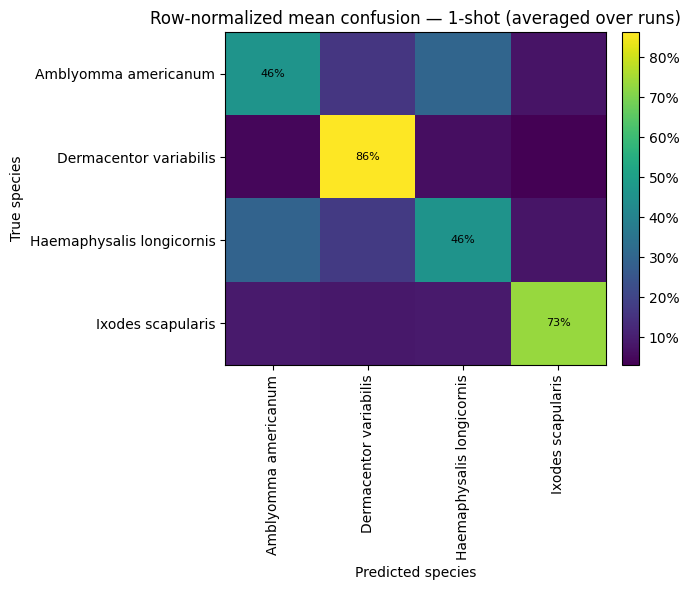

[PLOT] saved ../results/svm_bioclip/confusion_mean_rownorm_K03.png


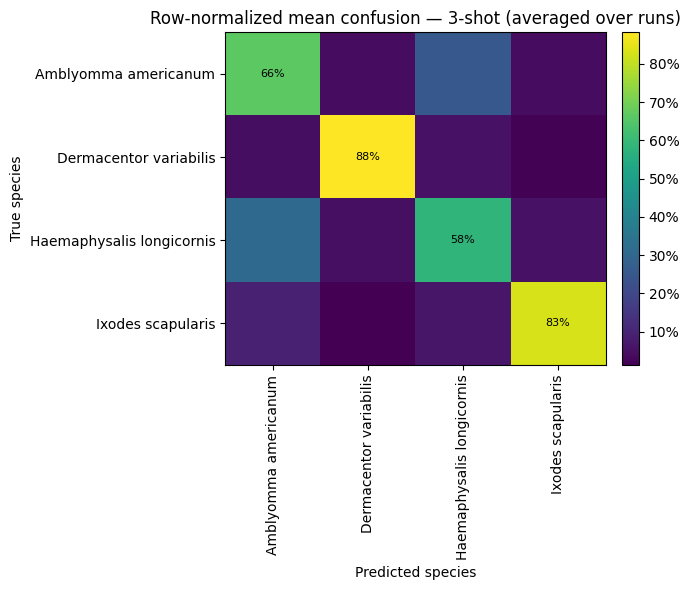

[PLOT] saved ../results/svm_bioclip/confusion_mean_rownorm_K05.png


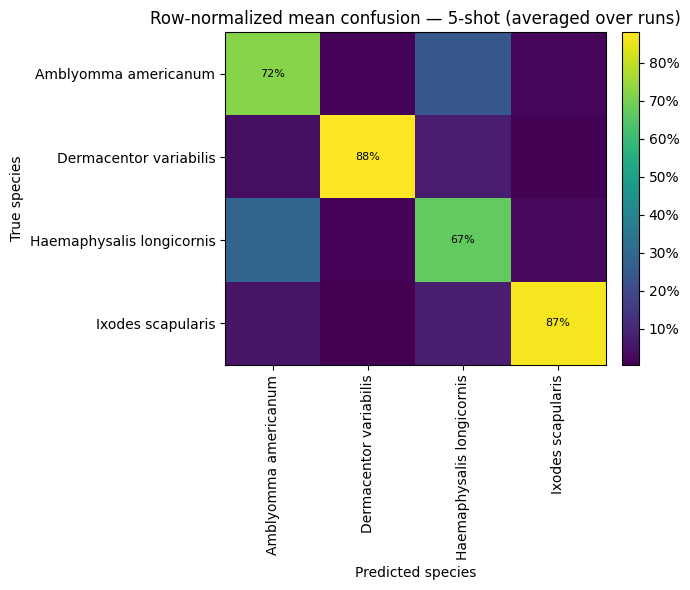

[PLOT] saved ../results/svm_bioclip/confusion_mean_rownorm_K10.png


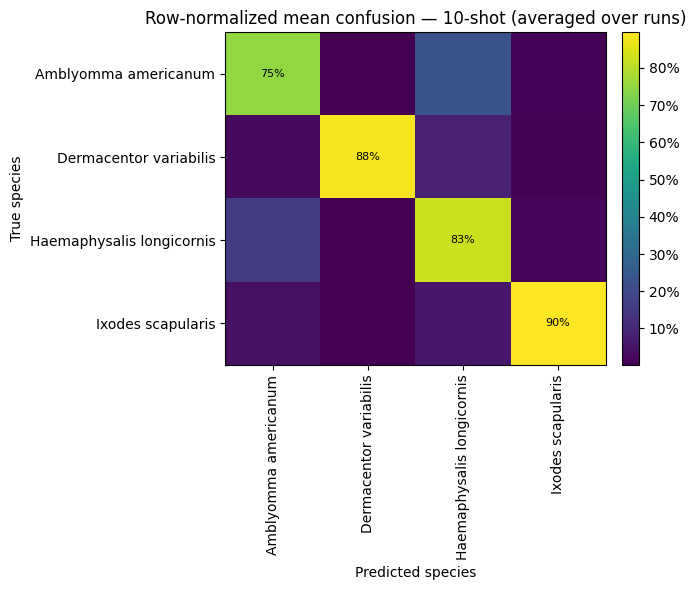

[PLOT] saved ../results/svm_bioclip/confusion_mean_rownorm_K25.png


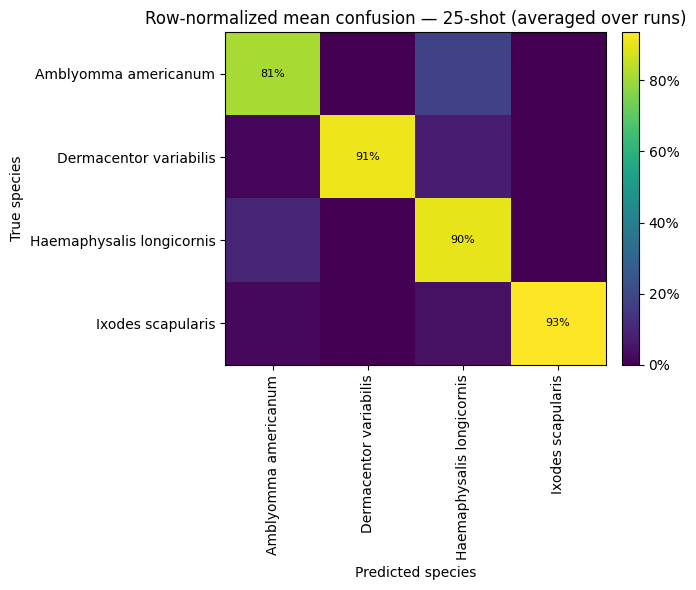

In [ ]:
# === Block 9A — Row-normalized mean confusion per K (averaged over runs) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

def mean_rownorm_confusion_for_K(df, K, class_order=None):
    """
    For a given shots K:
      - builds confusion per run (rows=true species)
      - row-normalizes each run's confusion
      - averages row-normalized matrices over runs (species with no test rows in a run are skipped for that row's average)
    Returns:
      classes (list), mean_conf (n_classes x n_classes), counts_per_row (how many runs contributed per row)
    """
    dK = df[df["shots"] == K].copy()
    if class_order is None:
        classes = sorted(pd.unique(dK["species_true"]))
    else:
        # keep only classes that actually appear at K (in case some drop out)
        classes = [c for c in class_order if c in set(dK["species_true"])]
    n = len(classes)
    if n == 0:
        raise ValueError(f"No classes present at K={K}.")

    # Accumulators
    mean_conf = np.zeros((n, n), dtype=float)
    row_counts = np.zeros(n, dtype=int)  # how many runs had nonzero test for that row

    for run_id, dKr in dK.groupby("run_id"):
        # confusion counts for this run
        ct = pd.crosstab(
            pd.Series(dKr["species_true"], name="true"),
            pd.Series(dKr["species_pred"], name="pred")
        )
        # align to full grid
        ct = ct.reindex(index=classes, columns=classes, fill_value=0)
        m = ct.to_numpy().astype(float)

        # row-normalize (skip rows with zero)
        row_sums = m.sum(axis=1, keepdims=True)
        nonzero_rows = (row_sums[:, 0] > 0)
        if not np.any(nonzero_rows):
            continue
        m_norm = np.zeros_like(m)
        m_norm[nonzero_rows] = m[nonzero_rows] / row_sums[nonzero_rows]

        mean_conf[nonzero_rows] += m_norm[nonzero_rows]
        row_counts[nonzero_rows] += 1

    # finalize mean: divide each row by number of contributing runs
    for i in range(n):
        if row_counts[i] > 0:
            mean_conf[i] /= row_counts[i]

    return classes, mean_conf, row_counts

def plot_mean_confusion(K, classes, mean_conf, counts_per_row, outpath):
    n = len(classes)
    fig_h = max(6, 0.45 * n)
    fig_w = max(7, 0.6 * n)
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    im = ax.imshow(mean_conf, aspect="auto")  # default colormap; normalized 0..1

    # axes + labels
    ax.set_xticks(range(n)); ax.set_yticks(range(n))
    ax.set_xticklabels(classes, rotation=90)
    ax.set_yticklabels(classes)
    ax.set_xlabel("Predicted species")
    ax.set_ylabel("True species")
    ax.set_title(f"Row-normalized mean confusion — {K}-shot (averaged over runs)")

    # colorbar in percentage
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.yaxis.set_major_formatter(PercentFormatter(1.0))

    # annotate diagonal (optional): show mean recall per species
    for i in range(n):
        ax.text(i, i, f"{mean_conf[i, i]*100:.0f}%",
                ha="center", va="center", fontsize=8, color="black")

    plt.tight_layout()
    outpath.parent.mkdir(parents=True, exist_ok=True)
#     plt.savefig(outpath, dpi=200, bbox_inches="tight")
    print(f"[PLOT] saved {outpath}")
    plt.show()

# Choose K values you want to present (e.g., all from SHOTS)
for K in SHOTS:
    classes, M, counts = mean_rownorm_confusion_for_K(df, K, class_order=CLASS_ORDER)
    plot_mean_confusion(K, classes, M, counts, RESULTS_ROOT / f"confusion_mean_rownorm_K{K:02d}.png")


[PLOT] saved ../results/svm_bioclip/simple_per_species_recall_vertical_K10.png


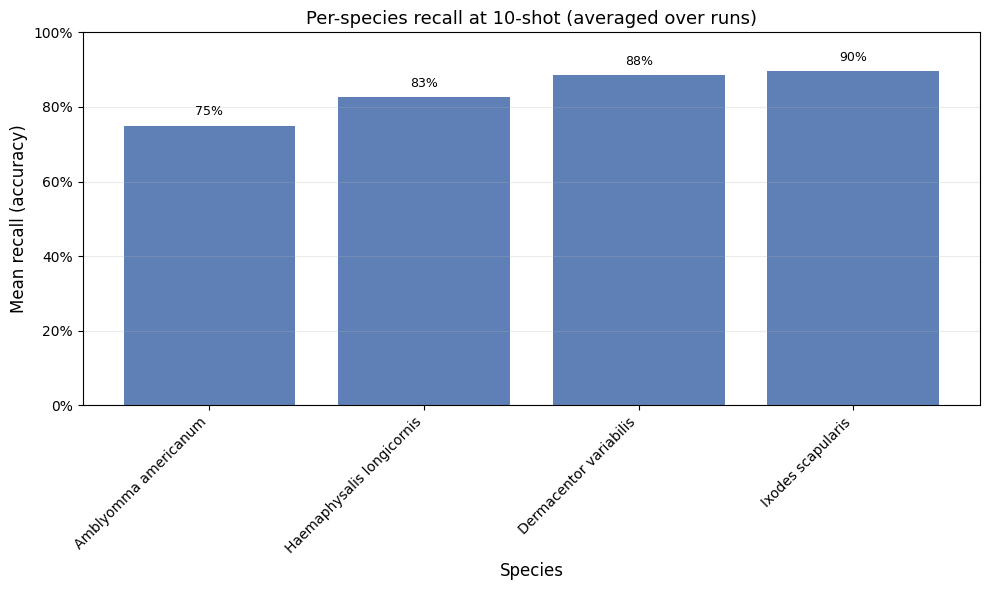

In [ ]:
# === Block 9B — Simple per-species recall bar chart (vertical version) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

K_BAR = 10  # choose which shot level to show
sub = per_species_summary[per_species_summary["shots"] == K_BAR].copy()
if len(sub) == 0:
    raise ValueError(f"No per-species summary found for shots={K_BAR}. Run Block 7 first.")

# Harmonize column names
if "species_true" in sub.columns and "species" not in sub.columns:
    sub = sub.rename(columns={"species_true": "species"})

# Sort from lowest → highest accuracy
sub = sub.sort_values("acc_mean", ascending=True).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 6))

# --- vertical bars ---
ax.bar(sub["species"], sub["acc_mean"], color="#4C72B0", alpha=0.9)

# --- format axes ---
ax.set_ylim(0, 1.0)
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.set_ylabel("Mean recall (accuracy)", fontsize=12)
ax.set_xlabel("Species", fontsize=12)
ax.set_title(f"Per-species recall at {K_BAR}-shot (averaged over runs)", fontsize=13)
ax.grid(axis="y", alpha=0.25)

# Rotate labels so they don’t overlap
plt.xticks(rotation=45, ha="right")

# Annotate bars with % values above them
for i, val in enumerate(sub["acc_mean"]):
    ax.text(i, val + 0.02, f"{val*100:.0f}%", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
out = RESULTS_ROOT / f"simple_per_species_recall_vertical_K{K_BAR:02d}.png"
# plt.savefig(out, dpi=200, bbox_inches="tight")
print(f"[PLOT] saved {out}")
plt.show()


## Block 10: error analysis

In [ ]:
# === Block 10 — Error analysis: Parquet + shortlists for misclassified samples ===

from pathlib import Path
import pandas as pd
import numpy as np


ANALYSIS_ROOT = RUN_DIR / "analysis"
ANALYSIS_ROOT.mkdir(parents=True, exist_ok=True)

# Path to your JSON metadata file (update if needed)
META_JSON = paths['processed_dir'] / 'final_data_no_ixodes.json'


# Helper functions 
def choose_most_dominant_value(series: pd.Series):
    """
    Return the most dominant (most frequent) non-null value in a Series.
    If there is a tie or no clear mode, fall back to the first non-null value.
    """
    s = series.dropna()
    if s.empty:
        return np.nan
    mode_values = s.mode()
    if len(mode_values) > 0:
        return mode_values.iloc[0]
    return s.iloc[0]

def count_incorrect(series: pd.Series) -> int:
    """Count how many entries are incorrect (assumes 0 = incorrect, 1 = correct)."""
    return int((series == 0).sum())

def count_correct(series: pd.Series) -> int:
    """Count how many entries are correct (assumes 0 = incorrect, 1 = correct)."""
    return int((series == 1).sum())

def select_top_k_samples(group: pd.DataFrame, k: int) -> pd.DataFrame:
    """
    Within a group (e.g., one species), select the top-k hardest samples,
    based on:
      1) number of incorrect predictions,
      2) incorrect rate,
      3) mean confidence overall.
    """
    return (
        group.sort_values(
            ["n_incorrect", "incorrect_rate", "mean_conf_overall"],
            ascending=[False, False, False],
        )
        .head(k)
    )

# ---------------------------------------------------------------------
# 1) Load latest MASTER predictions (Block 6 already updates this)
# ---------------------------------------------------------------------

MASTER_LATEST = RUN_DIR / "predictions.csv"
if not MASTER_LATEST.exists():
    raise FileNotFoundError(f"Could not find {MASTER_LATEST}. Run Block 6 first.")

df_pred = pd.read_csv(MASTER_LATEST)
print(f"[LOAD] MASTER = {MASTER_LATEST.name}, rows = {len(df_pred)}")

# Ensure types are consistent
df_pred["shots"] = df_pred["shots"].astype(int)
df_pred["run_id"] = df_pred["run_id"].astype(int)
df_pred["correct"] = df_pred["correct"].astype(int)
df_pred["sample_id"] = df_pred["sample_id"].astype(str)

# ---------------------------------------------------------------------
# 2) Load metadata from JSON (JSON gets updated so pulls fresh everytime)
# ---------------------------------------------------------------------

if not META_JSON.exists():
    raise FileNotFoundError(f"Metadata JSON not found at {META_JSON}. Update META_JSON path if needed.")

meta_df = pd.read_json(META_JSON)
meta_df["sample_id"] = meta_df["sample_id"].astype(str)

print(f"[LOAD] Metadata JSON = {META_JSON}, rows = {len(meta_df)}")
print("[META] Columns:", list(meta_df.columns))

# Expected fields in JSON:
# ['image_path', 'true_label', 'sample_id', 'view', 'sex', 'life_stage', 'attached']

# ---------------------------------------------------------------------
# 3) Collapse metadata to one row per sample_id
# ---------------------------------------------------------------------
# We want a per-sample summary: dominant labels + representative dorsal/ventral paths.

# Dominant scalar fields per sample
meta_sample = (
    meta_df
    .groupby("sample_id", as_index=False)
    .agg(
        true_label_dominant=("true_label", choose_most_dominant_value),
        sex_dominant=("sex", choose_most_dominant_value),
        life_stage_dominant=("life_stage", choose_most_dominant_value),
        attached_dominant=("attached", choose_most_dominant_value),
        n_images=("image_path", "size"),
    )
)

# Representative dorsal/ventral image paths
dorsal_paths = (
    meta_df[meta_df["view"] == "dorsal"]
    .groupby("sample_id")["image_path"]
    .first()
    .rename("dorsal_image_path")
)
ventral_paths = (
    meta_df[meta_df["view"] == "ventral"]
    .groupby("sample_id")["image_path"]
    .first()
    .rename("ventral_image_path")
)

meta_sample = (
    meta_sample
    .merge(dorsal_paths, on="sample_id", how="left")
    .merge(ventral_paths, on="sample_id", how="left")
)

print(f"[META] Collapsed metadata to {len(meta_sample)} unique sample_ids.")

# ---------------------------------------------------------------------
# 4) Build per-sample prediction summary from MASTER
# ---------------------------------------------------------------------
# Basic stats per sample_id
sample_stats = (
    df_pred
    .groupby("sample_id", as_index=False)
    .agg(
        n_rows=("correct", "size"),
        n_incorrect=("correct", count_incorrect),
        n_correct=("correct", count_correct),
        species_true_dominant=("species_true", choose_most_dominant_value),
        mean_conf_overall=("conf_top1", "mean"),
    )
)

sample_stats["incorrect_rate"] = sample_stats["n_incorrect"] / sample_stats["n_rows"]

# Most common wrong label per sample (if any)
wrong_rows = df_pred[df_pred["correct"] == 0].copy()

if len(wrong_rows) > 0:
    wrong_summary = (
        wrong_rows
        .groupby(["sample_id", "species_pred"], as_index=False)
        .agg(
            n_incorrect_pred=("species_pred", "size"),
            mean_conf_when_wrong=("conf_top1", "mean"),
        )
        .sort_values(
            ["sample_id", "n_incorrect_pred", "mean_conf_when_wrong"],
            ascending=[True, False, False],
        )
    )

    top_wrong_per_sample = (
        wrong_summary
        .groupby("sample_id", as_index=False)
        .head(1)
        .rename(
            columns={
                "species_pred": "most_common_pred",
                "n_incorrect_pred": "n_incorrect_to_most_common",
                "mean_conf_when_wrong": "mean_conf_to_most_common",
            }
        )
        [["sample_id", "most_common_pred", "n_incorrect_to_most_common", "mean_conf_to_most_common"]]
    )
else:
    # No misclassifications at all (unlikely, but safe)
    top_wrong_per_sample = pd.DataFrame(
        columns=["sample_id", "most_common_pred", "n_incorrect_to_most_common", "mean_conf_to_most_common"]
    )

sample_stats = sample_stats.merge(top_wrong_per_sample, on="sample_id", how="left")

# Error rate by shot level per sample (err_by_shot_K)
shot_stats = (
    df_pred
    .groupby(["sample_id", "shots"], as_index=False)
    .agg(
        n_rows_shot=("correct", "size"),
        n_incorrect_shot=("correct", count_incorrect),
    )
)

# Pivot shot-level error rates into columns
pivot_nrows = shot_stats.pivot(index="sample_id", columns="shots", values="n_rows_shot")
pivot_ninc = shot_stats.pivot(index="sample_id", columns="shots", values="n_incorrect_shot")
err_by_shot = pivot_ninc / pivot_nrows

# Rename columns like err_by_shot_1, err_by_shot_3, ...
err_by_shot.columns = [f"err_by_shot_{int(k)}" for k in err_by_shot.columns]
err_by_shot = err_by_shot.reset_index()

sample_stats = sample_stats.merge(err_by_shot, on="sample_id", how="left")

# Attach metadata to the sample stats
sample_summary = sample_stats.merge(meta_sample, on="sample_id", how="left")

print(f"[SAMPLE] sample_summary rows = {len(sample_summary)}")
print("[SAMPLE] Columns:", list(sample_summary.columns))

# ---------------------------------------------------------------------
# 5) Species-level summary and confusion summary
# ---------------------------------------------------------------------

# Confusion summary: counts and within-true rates for each (true, pred)
confusion_summary = (
    df_pred
    .groupby(["species_true", "species_pred"], as_index=False)
    .size()
    .rename(columns={"size": "count"})
)

true_totals = (
    confusion_summary
    .groupby("species_true", as_index=False)["count"]
    .sum()
    .rename(columns={"count": "true_total"})
)

confusion_summary = confusion_summary.merge(true_totals, on="species_true", how="left")
confusion_summary["rate_within_true"] = confusion_summary["count"] / confusion_summary["true_total"]

# Species-level error summary
species_summary = (
    df_pred
    .groupby("species_true", as_index=False)
    .agg(
        n_total_rows=("correct", "size"),
        n_total_incorrect=("correct", count_incorrect),
        n_total_correct=("correct", count_correct),
    )
)
species_summary["error_rate"] = species_summary["n_total_incorrect"] / species_summary["n_total_rows"]

# Most confused-with per species (ignore diagonal where true == pred)
wrong_confusion = confusion_summary[confusion_summary["species_true"] != confusion_summary["species_pred"]].copy()

if len(wrong_confusion) > 0:
    most_confused_with = (
        wrong_confusion
        .sort_values(["species_true", "count"], ascending=[True, False])
        .groupby("species_true", as_index=False)
        .head(1)
        .rename(
            columns={
                "species_pred": "most_confused_with",
                "count": "misclass_count",
                "rate_within_true": "misclass_rate_within_true",
            }
        )
        [["species_true", "most_confused_with", "misclass_count", "misclass_rate_within_true"]]
    )
else:
    most_confused_with = pd.DataFrame(
        columns=["species_true", "most_confused_with", "misclass_count", "misclass_rate_within_true"]
    )

species_summary = species_summary.merge(most_confused_with, on="species_true", how="left")

print(f"[SPECIES] species_summary rows = {len(species_summary)}")
print(f"[CONFUSION] confusion_summary rows = {len(confusion_summary)}")

# ---------------------------------------------------------------------
# 6) Stack everything into a single Parquet with a `table_name` tag
# ---------------------------------------------------------------------

sample_tbl = sample_summary.copy()
sample_tbl["table_name"] = "sample_summary"

species_tbl = species_summary.copy()
species_tbl["table_name"] = "species_summary"

conf_tbl = confusion_summary.copy()
conf_tbl["table_name"] = "confusion_summary"

ticks_analysis = pd.concat([sample_tbl, species_tbl, conf_tbl], ignore_index=True, sort=False)

parquet_path = ANALYSIS_ROOT / "ticks_analysis.parquet"
ticks_analysis.to_parquet(parquet_path, index=False)
print(f"[WRITE] Parquet written → {parquet_path}")

# ---------------------------------------------------------------------
# 7) Shortlists: global top misclassified + per-species top misclassified
# ---------------------------------------------------------------------

# Only keep samples that were misclassified at least once, and seen enough times
candidates = sample_summary[sample_summary["n_incorrect"] > 0].copy()

MIN_RUNS = 5  # you can tune this
candidates = candidates[candidates["n_rows"] >= MIN_RUNS]

# Global top K hardest samples
K_GLOBAL = 50
top_global = (
    candidates
    .sort_values(
        ["n_incorrect", "incorrect_rate", "mean_conf_overall"],
        ascending=[False, False, False]
    )
    .head(K_GLOBAL)
    .reset_index(drop=True)
)

top_global_path = ANALYSIS_ROOT / "top_misclassified_samples.csv"
top_global.to_csv(top_global_path, index=False)
print(f"[WRITE] Global top misclassified → {top_global_path} (rows = {len(top_global)})")

# Top K per species (based on dominant true species)
K_SPECIES = 10

top_per_species = (
    candidates
    .groupby("species_true_dominant", group_keys=True)
    .apply(lambda g: select_top_k_samples(g, K_SPECIES))
    .reset_index(drop=True)
)

top_per_species_path = ANALYSIS_ROOT / "top10_per_species.csv"
top_per_species.to_csv(top_per_species_path, index=False)
print(f"[WRITE] Per-species top misclassified → {top_per_species_path} (rows = {len(top_per_species)})")

# ---------------------------------------------------------------------
# 8) Quick preview in the notebook (so you can sanity-check)
# ---------------------------------------------------------------------

from IPython.display import display

print("\n[SAMPLE SUMMARY PREVIEW]")
display(sample_summary.head())

print("\n[SPECIES SUMMARY PREVIEW]")
display(species_summary.head())

print("\n[CONFUSION SUMMARY PREVIEW]")
display(confusion_summary.head())

print("\n[GLOBAL TOP MISCLASSIFIED PREVIEW]")
display(top_global.head())

print("\n[PER-SPECIES TOP MISCLASSIFIED PREVIEW]")
display(top_per_species.head())

print("\n✅ Block 10 complete: ticks_analysis.parquet + shortlists written.")


[LOAD] MASTER = master_predictions_latest.csv, rows = 268400
[LOAD] Metadata JSON = ../data/processed/final_data_no_ixodes.json, rows = 1160
[META] Columns: ['image_path', 'true_label', 'sample_id', 'view', 'sex', 'life_stage', 'attached']
[META] Collapsed metadata to 580 unique sample_ids.
[SAMPLE] sample_summary rows = 572
[SAMPLE] Columns: ['sample_id', 'n_rows', 'n_incorrect', 'n_correct', 'species_true_dominant', 'mean_conf_overall', 'incorrect_rate', 'most_common_pred', 'n_incorrect_to_most_common', 'mean_conf_to_most_common', 'err_by_shot_1', 'err_by_shot_3', 'err_by_shot_5', 'err_by_shot_10', 'err_by_shot_25', 'true_label_dominant', 'sex_dominant', 'life_stage_dominant', 'attached_dominant', 'n_images', 'dorsal_image_path', 'ventral_image_path']
[SPECIES] species_summary rows = 4
[CONFUSION] confusion_summary rows = 16
[WRITE] Parquet written → ../results/svm_bioclip/analysis/ticks_analysis.parquet
[WRITE] Global top misclassified → ../results/svm_bioclip/analysis/top_misclassi

/var/folders/tc/csl5ykwn1v36vwqf20swsn880000gn/T/ipykernel_15308/2743123547.py:322: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: select_top_k_samples(g, K_SPECIES))


,sample_id,n_rows,n_incorrect,n_correct,species_true_dominant,mean_conf_overall,incorrect_rate,most_common_pred,n_incorrect_to_most_common,mean_conf_to_most_common,...,err_by_shot_5,err_by_shot_10,err_by_shot_25,true_label_dominant,sex_dominant,life_stage_dominant,attached_dominant,n_images,dorsal_image_path,ventral_image_path
0,100-01,489,7,482,Dermacentor variabilis,0.580374,0.014315,Ixodes scapularis,3,0.250345,...,0.000000,0.000000,0.00000,Dermacentor variabilis,Female,Adult,,2,/Users/jayjivandas/Library/CloudStorage/OneDri...,/Users/jayjivandas/Library/CloudStorage/OneDri...
1,102-01,464,34,430,Ixodes scapularis,0.510443,0.073276,Haemaphysalis longicornis,13,0.280920,...,0.021277,0.000000,0.00000,Ixodes scapularis,Female,Adult,,2,/Users/jayjivandas/Library/CloudStorage/OneDri...,/Users/jayjivandas/Library/CloudStorage/OneDri...
2,104-01,467,178,289,Ixodes scapularis,0.385049,0.381156,Haemaphysalis longicornis,115,0.347385,...,0.393939,0.300000,0.22619,Ixodes scapularis,Female,Adult,,2,/Users/jayjivandas/Library/CloudStorage/OneDri...,/Users/jayjivandas/Library/CloudStorage/OneDri...
3,106-01,484,23,461,Dermacentor variabilis,0.502830,0.047521,Haemaphysalis longicornis,13,0.282298,...,0.040000,0.000000,0.00000,Dermacentor variabilis,Male,Adult,,2,/Users/jayjivandas/Library/CloudStorage/OneDri...,/Users/jayjivandas/Library/CloudStorage/OneDri...
4,107-01,480,26,454,Dermacentor variabilis,0.476293,0.054167,Haemaphysalis longicornis,17,0.309509,...,0.051020,0.020833,0.00000,Dermacentor variabilis,Male,Adult,,2,/Users/jayjivandas/Library/CloudStorage/OneDri...,/Users/jayjivandas/Library/CloudStorage/OneDri...



[SPECIES SUMMARY PREVIEW]


,species_true,n_total_rows,n_total_incorrect,n_total_correct,error_rate,most_confused_with,misclass_count,misclass_rate_within_true
0,Amblyomma americanum,40600,13306,27294,0.327734,Haemaphysalis longicornis,10003,0.246379
1,Dermacentor variabilis,149600,17401,132199,0.116317,Haemaphysalis longicornis,10313,0.068937
2,Haemaphysalis longicornis,13100,4703,8397,0.359008,Amblyomma americanum,3363,0.256718
3,Ixodes scapularis,65100,9889,55211,0.151905,Haemaphysalis longicornis,4444,0.068264



[CONFUSION SUMMARY PREVIEW]


,species_true,species_pred,count,true_total,rate_within_true
0,Amblyomma americanum,Amblyomma americanum,27294,40600,0.672266
1,Amblyomma americanum,Dermacentor variabilis,1984,40600,0.048867
2,Amblyomma americanum,Haemaphysalis longicornis,10003,40600,0.246379
3,Amblyomma americanum,Ixodes scapularis,1319,40600,0.032488
4,Dermacentor variabilis,Amblyomma americanum,5012,149600,0.033503



[GLOBAL TOP MISCLASSIFIED PREVIEW]


,sample_id,n_rows,n_incorrect,n_correct,species_true_dominant,mean_conf_overall,incorrect_rate,most_common_pred,n_incorrect_to_most_common,mean_conf_to_most_common,...,err_by_shot_5,err_by_shot_10,err_by_shot_25,true_label_dominant,sex_dominant,life_stage_dominant,attached_dominant,n_images,dorsal_image_path,ventral_image_path
0,149-01,493,476,17,Dermacentor variabilis,0.370886,0.965517,Haemaphysalis longicornis,288,0.392311,...,0.989899,0.989796,1.0,Dermacentor variabilis,Female,Adult,,2,/Users/jayjivandas/Library/CloudStorage/OneDri...,/Users/jayjivandas/Library/CloudStorage/OneDri...
1,ZOE-0096-01,486,471,15,Dermacentor variabilis,0.454568,0.969136,Haemaphysalis longicornis,370,0.496404,...,0.989899,1.000000,1.0,Dermacentor variabilis,Female,Adult,No,2,/Users/jayjivandas/Library/CloudStorage/OneDri...,/Users/jayjivandas/Library/CloudStorage/OneDri...
2,ZOE-0021-01,479,469,10,Dermacentor variabilis,0.366629,0.979123,Haemaphysalis longicornis,281,0.385279,...,0.978947,1.000000,1.0,Dermacentor variabilis,,Nymph,,2,/Users/jayjivandas/Library/CloudStorage/OneDri...,/Users/jayjivandas/Library/CloudStorage/OneDri...
3,560-01,484,468,16,Dermacentor variabilis,0.392979,0.966942,Haemaphysalis longicornis,329,0.416884,...,0.989899,1.000000,1.0,Dermacentor variabilis,Female,Adult,No,2,/Users/jayjivandas/Library/CloudStorage/OneDri...,/Users/jayjivandas/Library/CloudStorage/OneDri...
4,ZOE-0021-03,490,463,27,Dermacentor variabilis,0.371205,0.944898,Haemaphysalis longicornis,272,0.385813,...,0.989899,0.979798,1.0,Dermacentor variabilis,Female,Adult,,2,/Users/jayjivandas/Library/CloudStorage/OneDri...,/Users/jayjivandas/Library/CloudStorage/OneDri...



[PER-SPECIES TOP MISCLASSIFIED PREVIEW]


,sample_id,n_rows,n_incorrect,n_correct,species_true_dominant,mean_conf_overall,incorrect_rate,most_common_pred,n_incorrect_to_most_common,mean_conf_to_most_common,...,err_by_shot_5,err_by_shot_10,err_by_shot_25,true_label_dominant,sex_dominant,life_stage_dominant,attached_dominant,n_images,dorsal_image_path,ventral_image_path
0,428-01,451,371,80,Amblyomma americanum,0.366849,0.822616,Haemaphysalis longicornis,244,0.395998,...,0.817204,0.844444,0.945946,Amblyomma americanum,,Nymph,"Yes, less than 24 hours",2,/Users/jayjivandas/Library/CloudStorage/OneDri...,/Users/jayjivandas/Library/CloudStorage/OneDri...
1,201-01,446,365,81,Amblyomma americanum,0.418836,0.818386,Haemaphysalis longicornis,321,0.455541,...,0.840426,0.903614,0.986111,Amblyomma americanum,Female,Adult,,2,/Users/jayjivandas/Library/CloudStorage/OneDri...,/Users/jayjivandas/Library/CloudStorage/OneDri...
2,56-01,447,360,87,Amblyomma americanum,0.458798,0.805369,Haemaphysalis longicornis,349,0.490859,...,0.795699,0.901099,0.985507,Amblyomma americanum,Female,Adult,,2,/Users/jayjivandas/Library/CloudStorage/OneDri...,/Users/jayjivandas/Library/CloudStorage/OneDri...
3,31-03,448,358,90,Amblyomma americanum,0.425080,0.799107,Haemaphysalis longicornis,324,0.456392,...,0.812500,0.866667,0.984848,Amblyomma americanum,Female,Adult,,2,/Users/jayjivandas/Library/CloudStorage/OneDri...,/Users/jayjivandas/Library/CloudStorage/OneDri...
4,67-02,452,355,97,Amblyomma americanum,0.481507,0.785398,Haemaphysalis longicornis,346,0.518102,...,0.773196,0.885057,0.971831,Amblyomma americanum,Female,Adult,,2,/Users/jayjivandas/Library/CloudStorage/OneDri...,/Users/jayjivandas/Library/CloudStorage/OneDri...



✅ Block 10 complete: ticks_analysis.parquet + shortlists written.


In [ ]:
for name in ["per_species_accuracy.csv", "aggregated_metrics.csv", "shot_summary.csv", "ticks_analysis.parquet", "top_misclassified_samples.csv", "top10_per_species.csv"]:
    src = ANALYSIS_ROOT / name
    if src.exists():
        (LATEST_ANALYSIS / name).write_bytes(src.read_bytes())
        print(f"[LATEST] {name} → {LATEST_ANALYSIS / name}")
